In [3]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [4]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange, repeat
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma, GaborLayerGamma_, GaborLayerGammaRepeat
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-07-08 11:32:54.200373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 11:33:00.391512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-08 11:33:21.181851: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2024-07-08 11:33:21.181949: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:1: failed initializing StreamExecutor for CUDA device ordinal 1: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ER

In [6]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [7]:
dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_train = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [8]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

2024-07-08 11:33:22.524279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [1632]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [9]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

2024-07-08 11:33:23.065848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2880]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [10]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "INITIAL_LR": 1e-2,
    "PEAK_LR": 4e-2,
    "END_LR": 5e-3,
    "WARMUP_EPOCHS": 15,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
    "GABOR_KERNEL_SIZE": 31,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 16,
    # "N_GABORS": 128,
    "USE_GAMMA": True,
    "INIT_JH": True,
    "INIT_GABOR": True,
    "TRAIN_JH": False,
    "TRAIN_CS": False,
    "TRAIN_GABOR": False,
    "A_GABOR": False,
    "A_GDNSPATIOFREQORIENT": False,
    "TRAIN_ONLY_LAST_GDN": True,
}
config = ConfigDict(config)
config

A_GABOR: false
A_GDNSPATIOFREQORIENT: false
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: false
TRAIN_GABOR: false
TRAIN_JH: false
TRAIN_ONLY_LAST_GDN: true
USE_BIAS: false
USE_GAMMA: true
WARMUP_EPOCHS: 15
ZERO_MEAN: true

In [11]:
wandb.init(project="PerceptNet_v15",
           name="FinalModel_OnlyLast_Schedule",
           job_type="training",
           config=config,
           mode="disabled",
           )
config = config
config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


A_GABOR: false
A_GDNSPATIOFREQORIENT: false
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: false
TRAIN_GABOR: false
TRAIN_JH: false
TRAIN_ONLY_LAST_GDN: true
USE_BIAS: false
USE_GAMMA: true
WARMUP_EPOCHS: 15
ZERO_MEAN: true

In [12]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [13]:
#| exporti
class ChromaFreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between gamma_fuencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()
    n_scales: Sequence[int] = jnp.array([4, 2, 2], dtype=jnp.int32)
    n_orientations: Sequence[int] = jnp.array([8, 8, 8], dtype=jnp.int32)

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):

        gamma_f_a = self.param("gamma_f_a",
                             k_array(1/0.4, arr=jnp.array([2.,4.,8.,16.])),
                             (self.n_scales[0],))
        gamma_theta_a = self.param("gamma_theta_a",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[0],))
                                 (8,))

        gamma_f_t = self.param("gamma_f_t",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[1],))
        gamma_theta_t = self.param("gamma_theta_t",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[1],))
                                 (8,))
        
        gamma_f_d = self.param("gamma_f_d",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[2],))
        gamma_theta_d = self.param("gamma_theta_d",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[2],))
                                 (8,))

        H_cc = self.param("H_cc",
                          nn.initializers.ones_init(),
                          (3,3))

        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)

        ## Repeat gammas
        gamma_f = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_f = jnp.tile(gamma_f, reps=2)
        gamma_theta = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_theta = jnp.tile(gamma_theta, reps=2)

        ## Repeating
        cc = jnp.array([0,1,2])
        cc = jnp.repeat(cc, repeats=jnp.array([64,32,32]), total_repeat_length=len(fmean))

        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None,0,None,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, cc, cc, H_cc, 1)
        kernel = kernel[None,None,:,:]

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, c_1, c_2, H_cc, A=1):
        return H_cc[c_1,c_2]*A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [35]:
class GDNSpatioChromaFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = ChromaFreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return self.param("B", nn.initializers.ones_init(), (outputs.shape[-1],))*inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [16]:
class GaborLayerGammaHumanLike_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    n_scales: Sequence[int] # [A, T, D]
    n_orientations: Sequence[int] # [A, T, D]

    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1

    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False
    zero_mean: bool = False
    train_A: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 return_freq=False,
                 return_theta=False,
                 ):
        total_scales = jnp.sum(jnp.array(self.n_scales))
        total_orientations = jnp.sum(jnp.array(self.n_orientations))
        features = jnp.sum(jnp.array([s*o*len(self.phase) for s, o in zip(self.n_scales, self.n_orientations)]))

        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq_a = self.param("freq_a",
                           freq_scales_init(n_scales=self.n_scales[0], fs=self.fs),
                           (self.n_scales[0],))
        gammax_a = self.param("gammax_a",
                           k_array(k=0.4, arr=1/(freq_a**0.8)),
                           (self.n_scales[0],))
        gammay_a = self.param("gammay_a",
                            equal_to(gammax_a*0.8),
                            (self.n_scales[0],))
        theta_a = self.param("theta_a",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[0]),
                           (self.n_orientations[0],))
        sigma_theta_a = self.param("sigma_theta_a",
                                  equal_to(theta_a),
                                  (self.n_orientations[0],))

        freq_t = self.param("freq_t",
                           freq_scales_init(n_scales=self.n_scales[1], fs=self.fs),
                           (self.n_scales[1],))
        gammax_t = self.param("gammax_t",
                           k_array(k=0.4, arr=1/(freq_t**0.8)),
                           (self.n_scales[1],))
        gammay_t = self.param("gammay_t",
                            equal_to(gammax_t*0.8),
                            (self.n_scales[1],))
        theta_t = self.param("theta_t",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[1]),
                           (self.n_orientations[1],))
        sigma_theta_t = self.param("sigma_theta_t",
                                  equal_to(theta_t),
                                  (self.n_orientations[1],))

        freq_d = self.param("freq_d",
                           freq_scales_init(n_scales=self.n_scales[2], fs=self.fs),
                           (self.n_scales[2],))
        gammax_d = self.param("gammax_d",
                           k_array(k=0.4, arr=1/(freq_d**0.8)),
                           (self.n_scales[2],))
        gammay_d = self.param("gammay_d",
                            equal_to(gammax_d*0.8),
                            (self.n_scales[2],))
        theta_d = self.param("theta_d",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[2]),
                           (self.n_orientations[2],))
        sigma_theta_d = self.param("sigma_theta_d",
                                  equal_to(theta_d),
                                  (self.n_orientations[2],))

        # A = self.param("A",
        #                nn.initializers.ones_init(),
        #                (inputs.shape[-1], features)) if self.train_A else jnp.ones(shape=(inputs.shape[-1], features))
        A = self.param("A",
                       nn.initializers.ones_init(),
                       (inputs.shape[-1], 128))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            ## A
            kernel_a = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_a, gammay_a, freq_a, theta_a, sigma_theta_a, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_a = rearrange(kernel_a, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_a = repeat(kernel_a, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_a.shape[-1])

            ## T
            kernel_t = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_t, gammay_t, freq_t, theta_t, sigma_theta_t, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_t = rearrange(kernel_t, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_t = repeat(kernel_t, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_t.shape[-1])

            ## D
            kernel_d = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_d, gammay_d, freq_d, theta_d, sigma_theta_d, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_d = rearrange(kernel_d, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_d = repeat(kernel_d, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_d.shape[-1])

            ## Concat all of them
            kernel = jnp.concatenate([kernel_a, kernel_t, kernel_d], axis=-1)
            kernel = kernel * A[None,None,:,:]
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        fmean = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        fmean = jnp.tile(fmean, reps=2)
        theta_mean = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        theta_mean = jnp.tile(theta_mean, reps=2)

        if not had_batch: outputs = outputs[0]
        if return_freq and return_theta:
            return outputs + bias, fmean, theta_mean 
        elif return_freq and not return_theta:
            return outputs + bias, fmean
        elif not return_freq and return_theta:
            return outputs + bias, theta_mean
        else:
            return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, gammax, gammay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False, zero_mean=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        gamma_vector = jnp.array([gammax, gammay])
        inv_cov_matrix = jnp.diag(gamma_vector)**2
        # det_cov_matrix = 1/jnp.linalg.det(cov_matrix)
        # # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        # A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        A_norm = 1.
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ inv_cov_matrix @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [17]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        # outputs, fmean, theta_mean = GaborLayerGamma_(n_scales=4+2+2, n_orientations=8*3, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(n_scales=[4,2,2], n_orientations=[8,8,8], kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioChromaFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

## Define the metrics with `clu`

In [18]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [19]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [20]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [21]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [22]:
from functools import partial

In [23]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    if return_grads: return state, grads
    else: return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [24]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [36]:
if hasattr(config, "LEARNING_RATE"): tx = optax.adam(config.LEARNING_RATE)
else: tx = optax.adam(config.PEAK_LR)
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))

In [37]:
state.params.keys()

frozen_dict_keys(['GDNGamma_0', 'Color', 'GDN_0', 'CenterSurroundLogSigmaK_0', 'GDNGaussian_0', 'GaborLayerGammaHumanLike__0', 'GDNSpatioChromaFreqOrient_0'])

In [38]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
state = state.replace(state=_)

In [39]:
state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"].shape

(31, 31, 3, 128)

In [40]:
import matplotlib.pyplot as plt

In [41]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

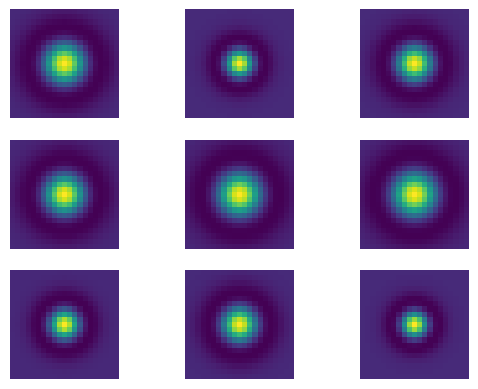

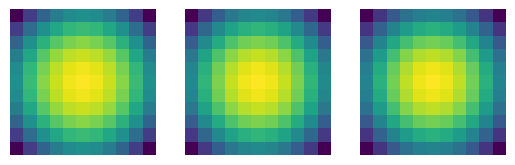

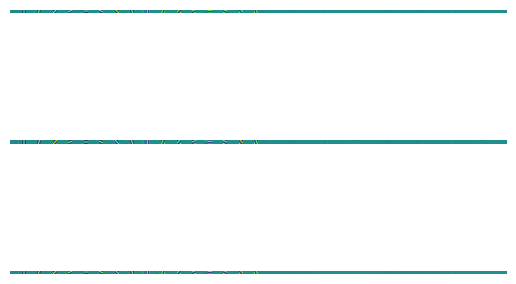

In [42]:
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

In [43]:
def check_trainable(path):
    if not config.A_GDNSPATIOFREQORIENT:
        if ("GDNSpatioChromaFreqOrient_0" in path) and ("A" in path):
            return True
    if "Color" in path:
        if not config.TRAIN_JH:
            return True
    if "CenterSurroundLogSigmaK_0" in path:
        if not config.TRAIN_CS:
            return True
    if "Gabor" in "".join(path):
        if not config.TRAIN_GABOR:
            return True
    if "GDNSpatioChromaFreqOrient_0" not in path and config.TRAIN_ONLY_LAST_GDN:
        return True
    return False

In [44]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDNGamma_0: {
        kernel: 'non_trainable',
        bias: 'non_trainable',
    },
    Color: {
        kernel: 'non_trainable',
    },
    GDN_0: {
        Conv_0: {
            kernel: 'non_trainable',
            bias: 'non_trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'non_trainable',
        K: 'non_trainable',
        A: 'non_trainable',
    },
    GDNGaussian_0: {
        GaussianLayerGamma_0: {
            gamma: 'non_trainable',
            A: 'non_trainable',
            bias: 'non_trainable',
        },
    },
    GaborLayerGammaHumanLike__0: {
        freq_a: 'non_trainable',
        gammax_a: 'non_trainable',
        gammay_a: 'non_trainable',
        theta_a: 'non_trainable',
        sigma_theta_a: 'non_trainable',
        freq_t: 'non_trainable',
        gammax_t: 'non_trainable',
        gammay_t: 'non_trainable',
        theta_t: 'non_trainable',
        sigma_theta_t: 'non_trainable',
        freq_d: 'non_trainable

In [46]:
if hasattr(config, "LEARNING_RATE"):
    tx = optax.adam(learning_rate=config.LEARNING_RATE)
else:
    steps_per_epoch = len(dst_train_rdy)
    epochs = 500
    schedule_lr = optax.warmup_cosine_decay_schedule(init_value=config.INITIAL_LR, peak_value=config.PEAK_LR, end_value=config.END_LR, warmup_steps=steps_per_epoch*config.WARMUP_EPOCHS, decay_steps=steps_per_epoch*config.EPOCHS)
    tx = optax.adam(learning_rate=schedule_lr)

optimizers = {
    "trainable": tx,
    "non_trainable": optax.set_to_zero(),
}

In [47]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [48]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [49]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(1062, 425)

In [50]:
wandb.run.summary["total_parameters"] = param_count
wandb.run.summary["trainable_parameters"] = trainable_param_count

In [51]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
if config.USE_GAMMA:
    state.params["GDNGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGamma_0"]["bias"])*0.1
    state.params["GDNGamma_0"]["kernel"] = jnp.ones_like(state.params["GDNGamma_0"]["kernel"])*0.5
else:
    state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
    state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Opponent color channel transformation
if config.INIT_JH:
    state.params["Color"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
                                                  [115.8404,-63.3502,41.26816],
                                                  [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["logsigma"] = jnp.array([-1.9,-1.9,-1.9,
                                                                   -1.76,-1.76,-1.76,
                                                                   -1.76,-1.76,-1.76])
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.1,1.1,
                                                            5.0,5.0,5.0,
                                                            5.0,5.0,5.0])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"])*0.1

## Gabor
if config.INIT_GABOR:
    state.params["GaborLayerGammaHumanLike__0"]["freq_a"] = jnp.array([2.,4.,8.,16.]) 
    state.params["GaborLayerGammaHumanLike__0"]["freq_t"] = jnp.array([3.,6.]) 
    state.params["GaborLayerGammaHumanLike__0"]["freq_d"] = jnp.array([3.,6.])

    state.params["GaborLayerGammaHumanLike__0"]["gammax_a"] = state.params["GaborLayerGammaHumanLike__0"]["freq_a"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_a"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_a"]

    state.params["GaborLayerGammaHumanLike__0"]["gammax_t"] = state.params["GaborLayerGammaHumanLike__0"]["freq_t"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_t"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_t"]

    state.params["GaborLayerGammaHumanLike__0"]["gammax_d"] = state.params["GaborLayerGammaHumanLike__0"]["freq_d"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_d"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_d"]
    # state.params["GaborLayerGammaHumanLike__0"]["theta_a"] = jnp.tile(jnp.linspace(0., jnp.pi, num=16), reps=128//16)
    # state.params["GaborLayerGammaHumanLike__0"]["sigma_theta_a"] = state.params["GaborLayerGammaHumanLike__0"]["theta_a"]
    # state.params["GaborLayerGammaHumanLike__0"]["phase_a"] = jnp.repeat(jnp.array([0., 90.]), repeats=64)    

    A_a = jnp.zeros(shape=(3,64), dtype=jnp.float32)
    A_a = A_a.at[0,:].set(1.)
    A_t = jnp.zeros(shape=(3,32), dtype=jnp.float32)
    A_t = A_t.at[1,:].set(1.)
    A_d = jnp.zeros(shape=(3,32), dtype=jnp.float32)
    A_d = A_d.at[2,:].set(1.)
    state.params["GaborLayerGammaHumanLike__0"]["A"] = jnp.concatenate([A_a, A_t, A_d], axis=-1)

## GDNSpatioChromaFreqOrient
# state.params["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
# state.params["GDNSpatioChromaFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"])*(1/20)
# state.params["GDNSpatioChromaFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["H_cc"] = jnp.eye(3,3)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"])*(1/20)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"])*(1/20)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"])*(1/20)


state = state.replace(params=freeze(state.params))

In [52]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
state = state.replace(state=_)

In [53]:
gs = state.params["GaborLayerGammaHumanLike__0"]

In [ ]:
kernel = state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"]
kernel_c = rearrange(kernel, "x y c_in (c phase theta freq) -> x y c_in (phase theta freq) c", c=4, phase=2, theta=8, freq=2)
kernel.shape, kernel_c.shape

((31, 31, 3, 128), (31, 31, 3, 32, 4))

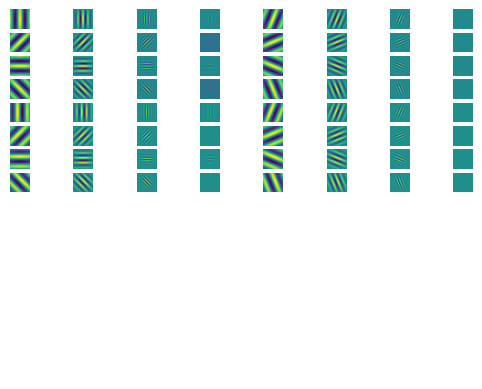

In [ ]:
fig, axes = plt.subplots(16,8)
for i, ax in enumerate(axes.ravel()):
    k = state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"][...,0,i]
    ax.imshow(k/k.max())

for ax in axes.ravel(): ax.axis("off")
plt.show()

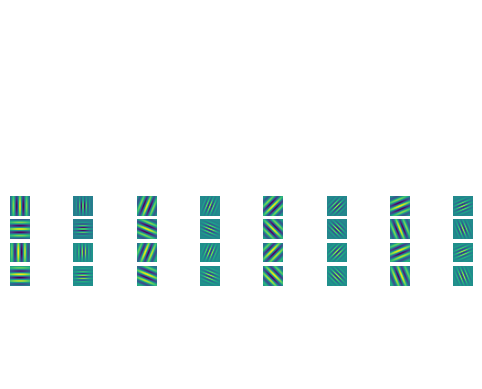

In [ ]:
fig, axes = plt.subplots(16,8)
for i, ax in enumerate(axes.ravel()):
    k = state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"][...,1,i]
    ax.imshow(k/k.max())

for ax in axes.ravel(): ax.axis("off")
plt.show()

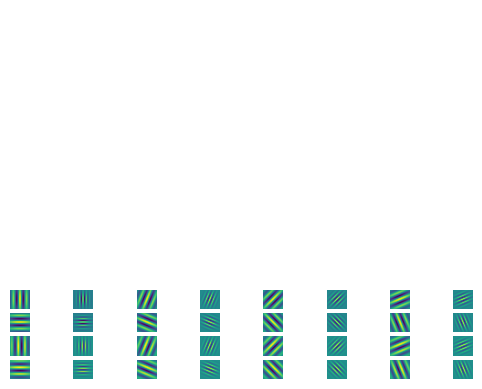

In [ ]:
fig, axes = plt.subplots(16,8)
for i, ax in enumerate(axes.ravel()):
    k = state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"][...,2,i]
    ax.imshow(k/k.max())

for ax in axes.ravel(): ax.axis("off")
plt.show()

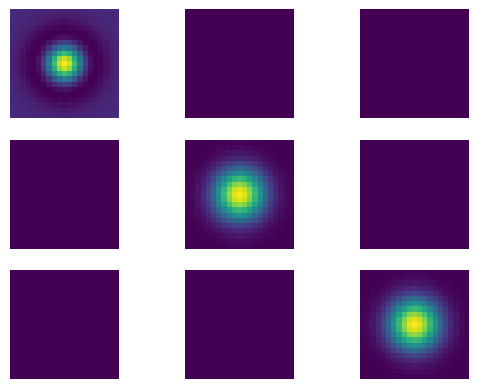

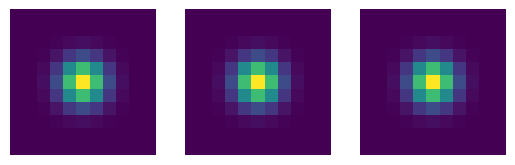

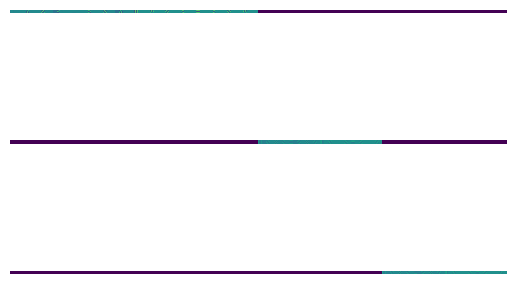

In [ ]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [54]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [55]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-0"), state, save_args=save_args, force=True) # force=True means allow overwritting.

In [56]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [57]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

2024-07-08 11:38:13.899160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1632]
	 [[{{node Placeholder/_1}}]]


In [58]:
from functools import partial

In [59]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [60]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [61]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 20min 36s, sys: 8.69 s, total: 20min 45s
Wall time: 22.4 s


(64, 96, 128, 128)

In [62]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 2h 7min 5s, sys: 2min 30s, total: 2h 9min 36s
Wall time: 2min 44s


In [ ]:
# jax.config.update("jax_debug_nans", True)

In [ ]:
def filter_extra(extra):
    def filter_intermediates(path, x):
        path = "/".join(path)
        if "Gabor" in path:
            return (x[0][0],)
        else: 
            return x
    extra = unfreeze(extra)
    extra["intermediates"] = flax.traverse_util.path_aware_map(filter_intermediates, extra["intermediates"])
    return freeze(extra)

In [ ]:
%%time
step = 0
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_param(state.params, "A", a_min=0))
        state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        step += 1
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])
    extra = filter_extra(extra) ## Needed because the Gabor layer has multiple outputs
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.
    # orbax_checkpointer.save(os.path.join(wandb.run.dir, f"model-{epoch+1}"), state, save_args=save_args, force=False) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, "learning_rate": schedule_lr(step), **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

Epoch 0 -> [Train] Loss: -0.49237510561943054 [Val] Loss: -0.7113361954689026
Epoch 1 -> [Train] Loss: -0.6442224979400635 [Val] Loss: -0.8021577000617981
Epoch 2 -> [Train] Loss: -0.7758544087409973 [Val] Loss: -0.8238145709037781
Epoch 3 -> [Train] Loss: -0.8032200932502747 [Val] Loss: -0.8246150612831116
Epoch 4 -> [Train] Loss: -0.7833956480026245 [Val] Loss: -0.8281277418136597
Epoch 5 -> [Train] Loss: -0.781570315361023 [Val] Loss: -0.8271215558052063
Epoch 6 -> [Train] Loss: -0.7834862470626831 [Val] Loss: -0.8289475440979004
Epoch 7 -> [Train] Loss: -0.797070324420929 [Val] Loss: -0.8304378390312195
Epoch 8 -> [Train] Loss: -0.7982140183448792 [Val] Loss: -0.8310251235961914
Epoch 9 -> [Train] Loss: -0.7965611219406128 [Val] Loss: -0.8306598663330078
Epoch 10 -> [Train] Loss: -0.8054355978965759 [Val] Loss: -0.830310583114624
Epoch 11 -> [Train] Loss: -0.8026095628738403 [Val] Loss: -0.8303963541984558
Epoch 12 -> [Train] Loss: -0.8121331334114075 [Val] Loss: -0.830127894878387

In [ ]:
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["H_cc"]

Array([[1.8959270e-01, 1.4515939e+01, 4.7175870e+00],
       [4.4316579e-02, 1.6884203e+00, 6.7684092e-03],
       [0.0000000e+00, 0.0000000e+00, 2.1671425e+01]], dtype=float32)

Save the final model as well in case we want to keep training from it or whatever:

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()

In [ ]:
import matplotlib.pyplot as plt

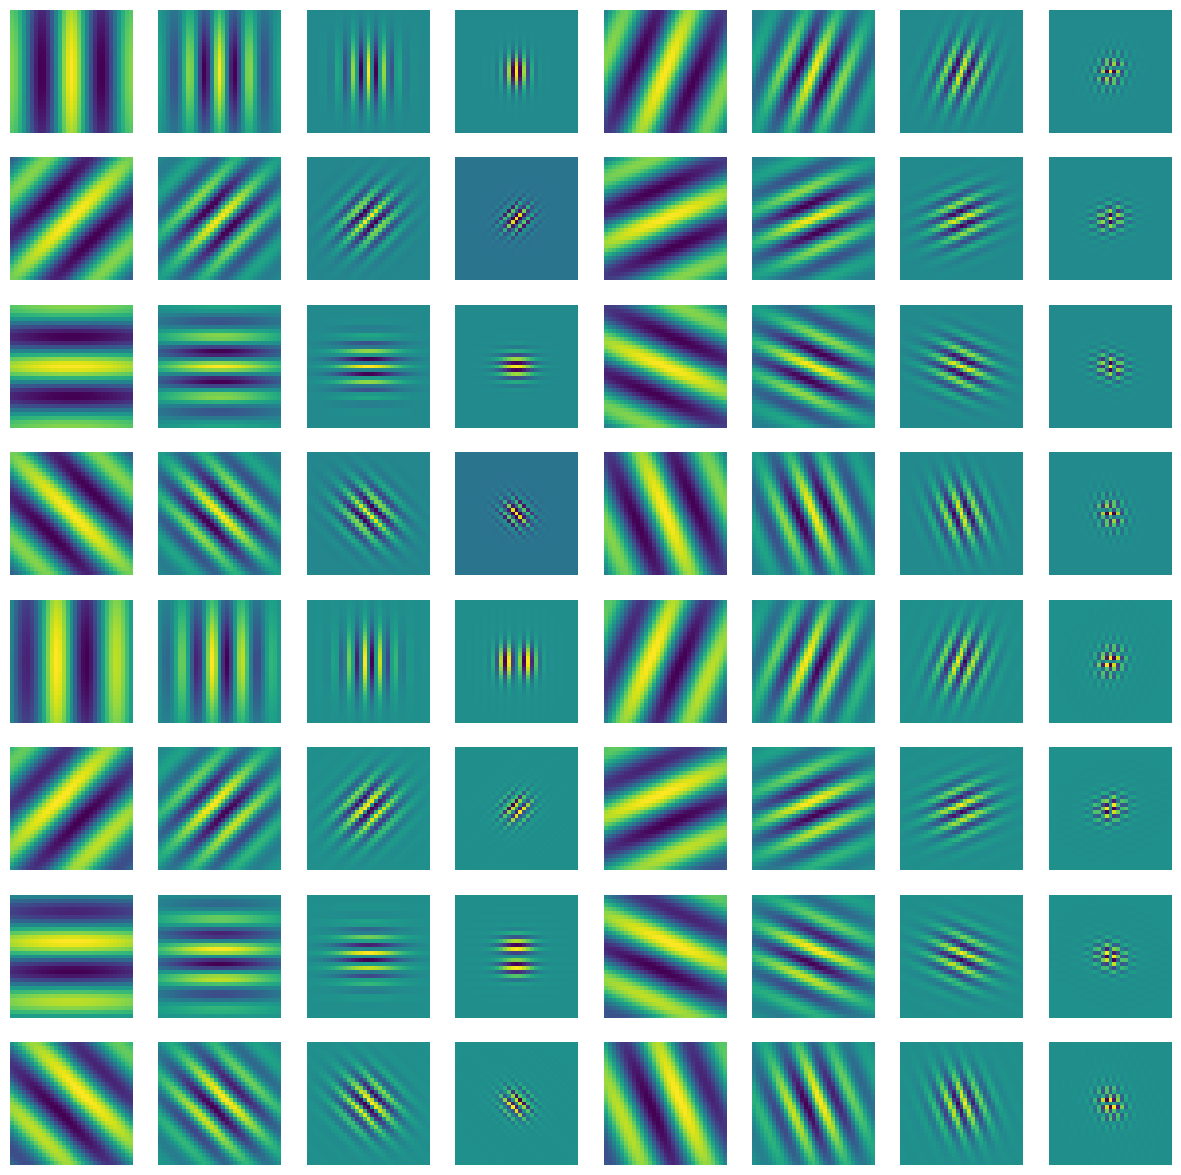

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [ ]:
kernel = state.state["precalc_filter"]["GaborLayerGammaHumanLike__0"]["kernel"]
kernel.shape

(31, 31, 3, 128)

In [ ]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

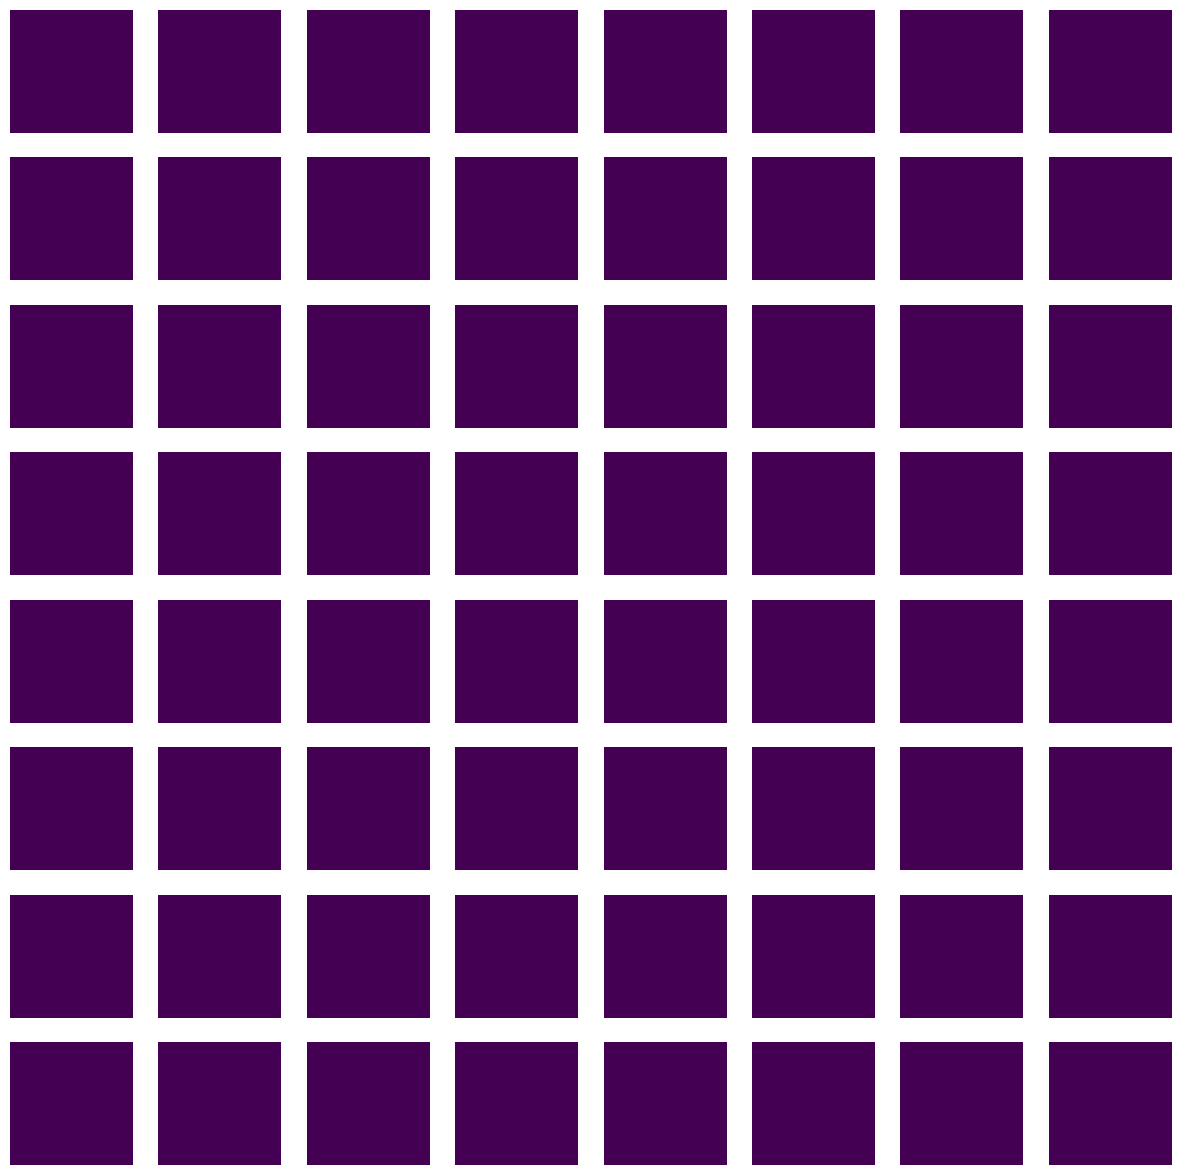

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

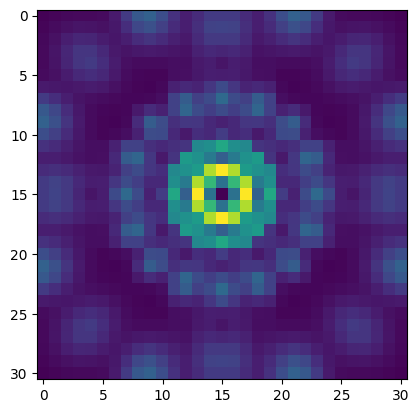

In [ ]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()